In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.gaussian_process import kernels
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
sampler = GaussianProcessRegressor(kernel=kernels.RBF((1, 1)))

In [4]:
np.random.seed(1)

37


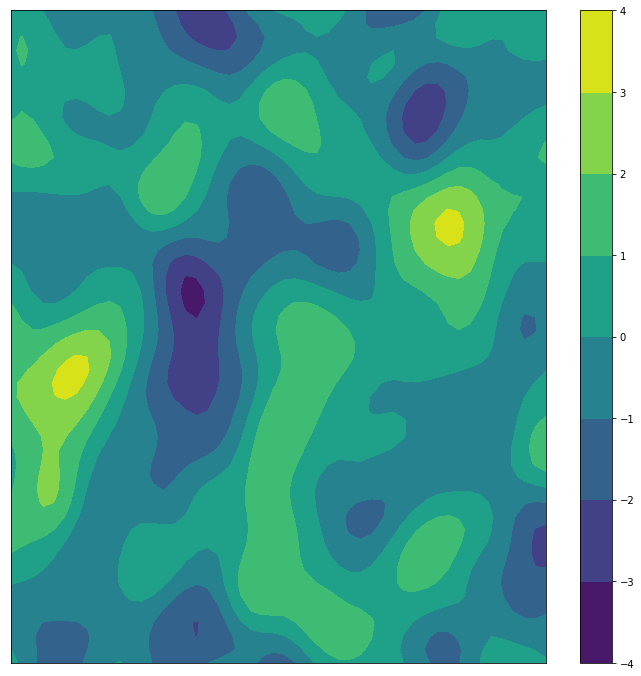

In [5]:
n = 50
w, h = 15, 15
rng = np.random.randint(0, 2**10)

xx, yy = np.meshgrid(np.linspace(0,w,n), np.linspace(0,h,n))
points = np.stack([xx.ravel(), yy.ravel()]).T
Z = sampler.sample_y(points, random_state=468).reshape(n, n)

print(rng)
plt.figure(figsize=(12,12))
plt.contourf(xx, yy, Z)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

In [61]:
import sys
import torch
from torchvision import transforms
from torchvision.models import resnet50
sys.path.append('..')
from adversarial.functional import pgd, iterated_fgsm
from adversarial.datasets import RestrictedImageNet

In [15]:
DEVICE = 'cuda'

In [102]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

In [103]:
data = RestrictedImageNet(transform)
len(data)

25200

In [104]:
def unnormalise(x):
    for i, (mean, std) in enumerate(zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])):
        x[i, :, :] = x[i, :, :]*std + mean
        
    return x

In [105]:
model = resnet50(pretrained=True).to(DEVICE).eval()

In [183]:
# Get image
def adversarial_example_diagram(data_index):
    x, y = data[data_index]
    x_plot = unnormalise(x).permute(1, 2, 0).cpu().numpy()
    y = torch.Tensor([y]).to(DEVICE)
    x = x.unsqueeze(0).to(DEVICE)

    # Get regular prediction
    y_pred = model(x)
    pred_class = y_pred.argmax(dim=1)
    print(f'P({pred_class.item()}) = '
         f'{np.round(y_pred.softmax(dim=1)[0, pred_class].item(), 2)}')

    # Made advex
    x_adv = pgd(model, x, torch.Tensor([y]).to(DEVICE).long(), torch.nn.CrossEntropyLoss(),
                k=200, step=0.05, eps=1, norm=2,
#                 k=200, step=0.5, eps=10, norm=2,  # Visible perturbation
                y_target=torch.Tensor([891]).to(DEVICE).long(),
               )

    y_pred_adv = model(x_adv)
    pred_class_adv = y_pred_adv.argmax(dim=1)
    print(f'P({pred_class_adv.item()}) = {y_pred_adv.softmax(dim=1)[0, pred_class_adv].item()}')

    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    axes[0].imshow(x_plot)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Adversarial perturbation scaled for increased visibility
    axes[1].imshow(unnormalise(100*(x_adv - x).squeeze(0)).permute(1, 2, 0).cpu().numpy())
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # axes[2].imshow(unnormalise(x_adv.squeeze(0)).permute(1, 2, 0).cpu().numpy())
    axes[2].imshow((x_adv.squeeze(0)).permute(1, 2, 0).cpu().numpy())
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    plt.show()
    
    return x, x_adv - x, x_adv, y_pred

P(15) = 0.65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


P(891) = 0.999906063079834


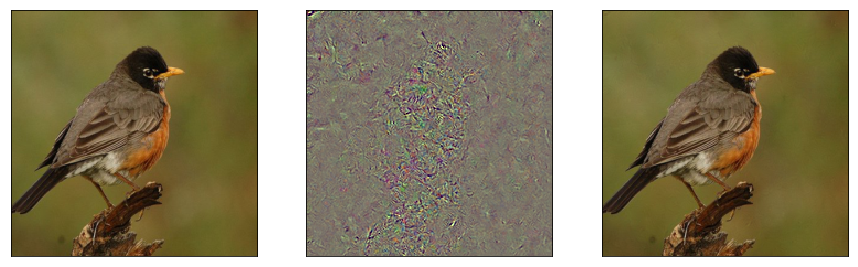

In [206]:
x, perturbation, x_adv, y_pred = adversarial_example_diagram(12003)

15 is robin, 891 is waffle-iron: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [198]:
y_pred = y_pred.softmax(dim=1).detach().cpu()[0].numpy()

In [200]:
df = pd.DataFrame({'class_index': range(1000), 'p': y_pred})

In [203]:
df.sort_values('p',ascending=False)

,class_index,p
91,91,5.222049e-01
15,15,3.241727e-01
86,86,4.160402e-02
10,10,2.150728e-02
82,82,1.579487e-02
298,298,1.188736e-02
81,81,1.119635e-02
13,13,1.031442e-02
138,138,7.427048e-03
83,83,5.520625e-03


In [209]:
pd.DataFrame({
    'class_index': range(1000),
    'p': model(perturbation).softmax(dim=1).detach().cpu()[0].numpy()
}).sort_values('p',ascending=False)

,class_index,p
499,499,0.022196
473,473,0.014049
604,604,0.013569
813,813,0.011381
623,623,0.011309
846,846,0.010239
674,674,0.009217
892,892,0.008631
418,418,0.008434
644,644,0.008361
